In [1]:
%run StoreTweetsBackend.ipynb

{'limit': 15, 'remaining': 15, 'reset': 1614817246}
{'limit': 900, 'remaining': 900, 'reset': 1614817246}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


In [ ]:
!conda update --all

In [2]:
stockData= pd.read_csv("project/archive/Stocks/tsla.us.txt",parse_dates=[0])
print(stockData['Date'].min(), stockData['Date'].max())
cols = [ "OpenInt"]
# cols = [ "Date","Open","High","Low","Close","Volume","OpenInt"]
stockData.drop(cols, axis=1, inplace=True)
stockData = stockData.sort_values('Date')
stockData.isnull().sum()
stockData["Date"]

2010-06-28 00:00:00 2017-11-10 00:00:00


0      2010-06-28
1      2010-06-29
2      2010-06-30
3      2010-07-01
4      2010-07-02
          ...    
1853   2017-11-06
1854   2017-11-07
1855   2017-11-08
1856   2017-11-09
1857   2017-11-10
Name: Date, Length: 1858, dtype: datetime64[ns]

In [3]:
rng=pd.date_range(stockData['Date'].min(), stockData['Date'].max())
# rnglist=rng.tolist()
# testpts = range(100,121)

In [4]:
print(rng[0].strftime('%Y-%m-%d'),stockData["Date"][0])
for i in rng:
    if((rng[0].strftime('%Y-%m-%d')==stockData["Date"]).sum()>1):
        print ((rng[0].strftime('%Y-%m-%d')==stockData["Date"]).sum())
    elif((rng[0].strftime('%Y-%m-%d')==stockData["Date"]).sum()==0):
        print ("missing data: ",rng[0].strftime('%Y-%m-%d'))

2010-06-28 2010-06-28 00:00:00


In [6]:
# rng=pd.date_range(stockData['Date'].min(), stockData['Date'].max())
# stockData["Date"][0]
stockData["Date"][0]

Timestamp('2010-06-28 00:00:00')

In [7]:
# datetime.date(2015,1,1) + timedelta(years=+1)
# print(rnglist[0],stockData['Date'].min())
# datetime.datetime.fromtimestamp(rnglist[0]).Date==stockData['Date'].min()

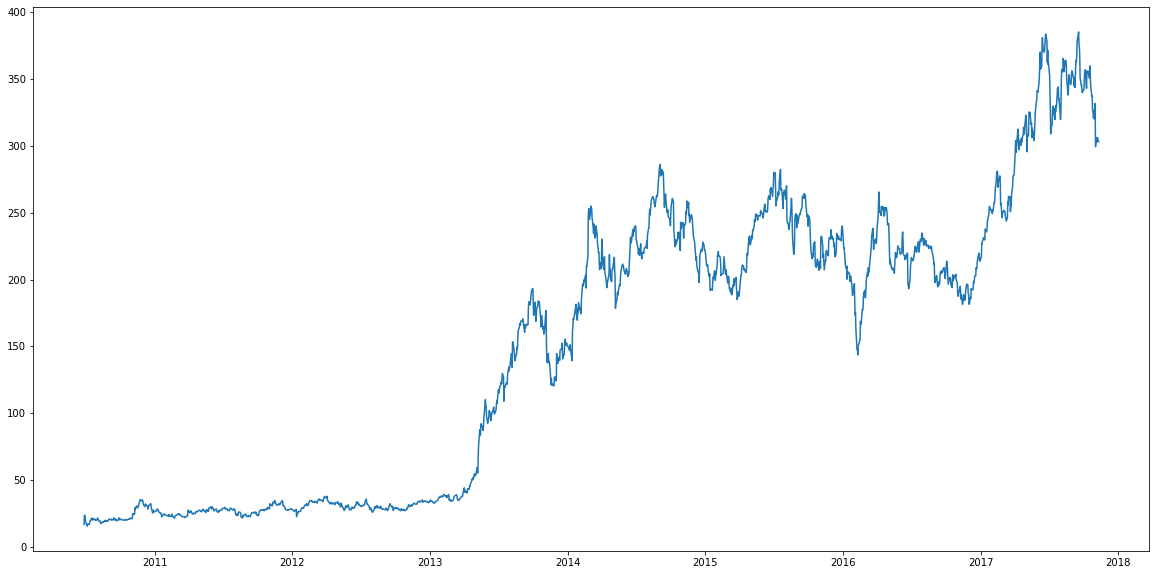

In [10]:
format = '%Y-%m-%d'
stockData['Datetime'] = pd.to_datetime(stockData['Date'] , format=format)
stockData = stockData.set_index(pd.DatetimeIndex(stockData['Datetime']))
stockData.drop(columns=['Datetime','Date'], inplace=True)
plt.figure(figsize=(20,10))
plt.plot(stockData["Close"])

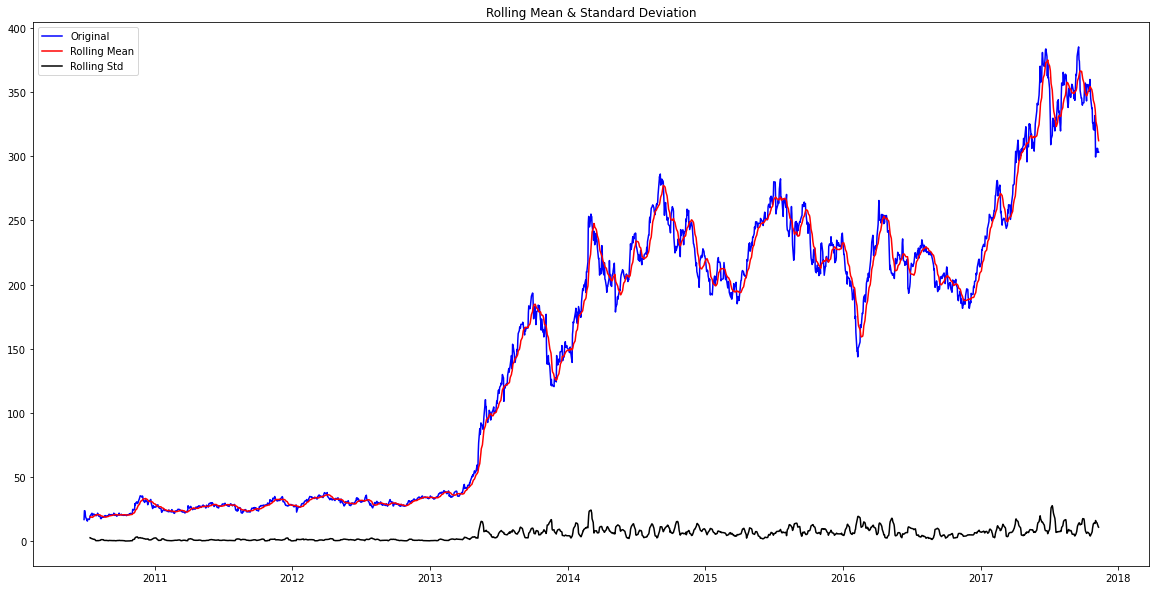

Results of Dickey-Fuller Test:
Test Statistic                   -0.842866
p-value                           0.806205
#Lags Used                        1.000000
Number of Observations Used    1856.000000
Critical Value (1%)              -3.433878
Critical Value (5%)              -2.863099
Critical Value (10%)             -2.567600
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data,x="Close",period=12):
    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    r=data.rolling(period)
    plt.plot(data[x], color='blue',label='Original')
    plt.plot(r.mean()[x], color='red', label='Rolling Mean')
    plt.plot(r.std()[x], color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(data[x], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


test_stationarity(stockData,x="Close",period=12) 

Text(0.5, 1.0, 'Log')

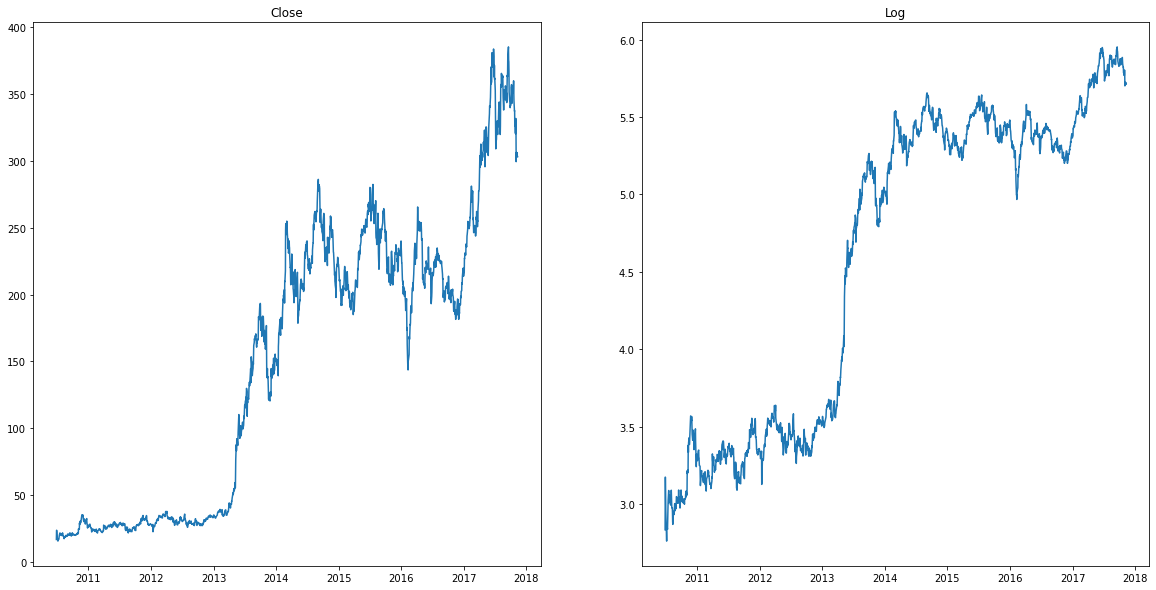

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot((stockData["Close"]))
plt.title("Close")
plt.subplot(122)
plt.plot(np.log(stockData["Close"]))
plt.title("Log")


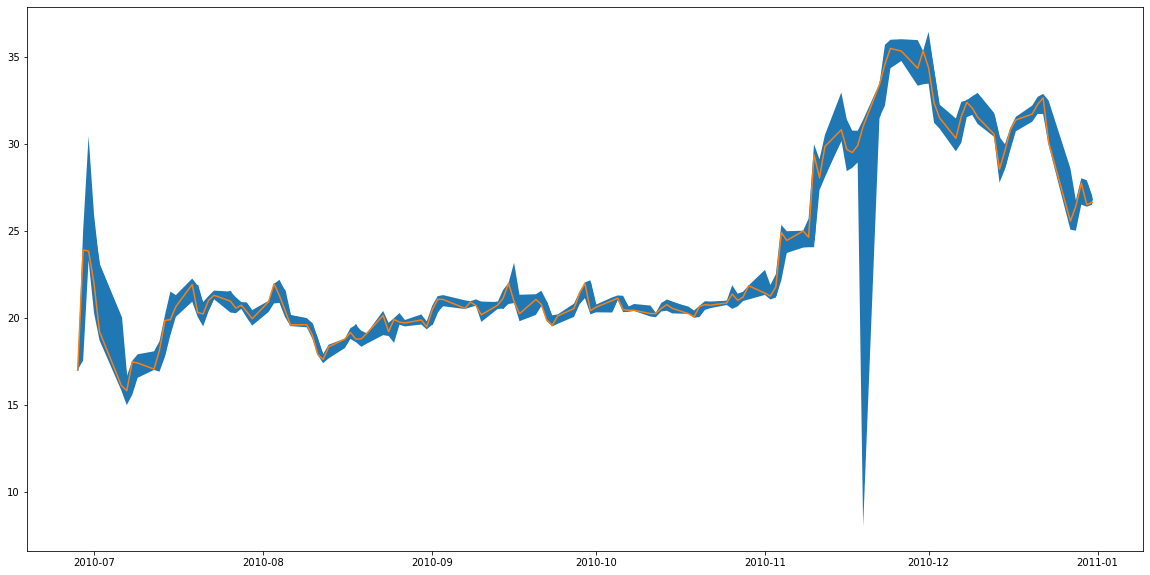

In [18]:
plt.figure(figsize=(20,10))
plt.plot(stockData.loc["2010"]["Open"])
plt.plot(stockData.loc["2010"]["Close"])
plt.fill_between(stockData.loc["2010"].index,stockData.loc["2010"]["Low"], stockData.loc["2010"]["High"])
# plt.plot(stockData.loc["2010"]["Date"],stockData.loc["2010"]["High"])
# plt.plot(stockData.loc["2010"]["Date"],stockData.loc["2010"]["Low"])

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(x=stockData["2013"]['Close'], model='additive', extrapolate_trend='freq', period=30)
plt.rcParams.update({'figure.figsize': (20,20)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
stockDataLog=np.log(stockData)
rolling_windows=stockDataLog.rolling(12)
moving_avg = rolling_windows.mean()
plt.plot(stockDataLog["Close"])
plt.plot(moving_avg["Close"], color='red')

In [ ]:
ts_log_moving_avg_diff = stockDataLog - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
 
test_stationarity(ts_log_moving_avg_diff,x="Close",period=12)

In [ ]:
expwighted_avg = stockDataLog.ewm(halflife=12).mean()
plt.figure(figsize=(20,10))
plt.plot(stockDataLog["Close"])
plt.plot(expwighted_avg["Close"], color='red')
ts_log_ewma_diff = stockDataLog - expwighted_avg


test_stationarity(ts_log_ewma_diff,x="Close",period=12)


In [ ]:
ts_log_diff = stockDataLog - stockDataLog.shift()
plt.plot(ts_log_diff.loc["2011"]["Close"])
ts_log_diff.dropna(inplace=True)


In [ ]:
test_stationarity(ts_log_diff,"Close")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(x=stockDataLog["2013"]['Close'], model='additive', extrapolate_trend='freq', period=30)
plt.rcParams.update({'figure.figsize': (20,20)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
ts_log_decompose =result_add.resid
ts_log_decompose.dropna(inplace=True)
f=ts_log_decompose.to_frame() 
f=f.rename({"Datetime":'Datetime',"resid":"Close"}, axis='columns')
test_stationarity(f)

In [ ]:
ts_log=stockDataLog.loc["2013"]['Close']
ts_log.index = pd.DatetimeIndex(ts_log.index).to_period('D')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)


In [ ]:
# plt.plot(results_AR.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [ ]:
# model = ARIMA(ts_log, order=(0, 1, 2))  
# results_MA = model.fit(disp=-1)  
# plt.plot(ts_log_diff)


In [ ]:
# ff=results_MA.fittedvalues
# ff=ff.to_timestamp()
# ff=ff
# plt.plot(ff, color='red')
# plt.title('RSS: %.4f'% sum((ff-ts_log_diff.loc["2013"]['Close'])**2))

In [ ]:
# ts_log_diff=ts_log_diff.loc["2013"]['Close']
# ff=ff
# ff=ff.asfreq('D')
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1).fittedvalues.to_timestamp() 
results_ARIMA=results_ARIMA.asfreq('D')
plt.plot(ts_log_diff)
plt.plot(results_ARIMA, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA-ts_log_diff)**2))